In [1]:
!pip install transformers datasets scikit-learn tqdm matplotlib seaborn --quiet
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [3]:
# 3. Load and Preprocess the MRPC Dataset
# Load MRPC from GLUE benchmark
dataset = load_dataset('glue', 'mrpc')

# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['sentence1'], example['sentence2'], truncation=True, padding='max_length', max_length=128)

# Apply tokenization
encoded_dataset = dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

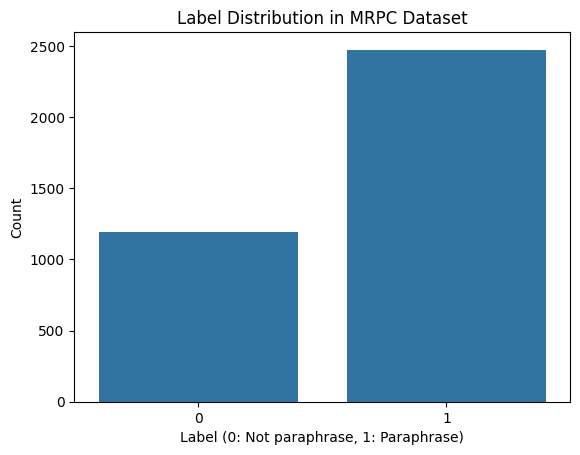

In [4]:
# 4. Visualize Dataset Label Distribution
labels = dataset['train']['label']
sns.countplot(x=labels)
plt.title("Label Distribution in MRPC Dataset")
plt.xlabel("Label (0: Not paraphrase, 1: Paraphrase)")
plt.ylabel("Count")
plt.show()

In [5]:
# 5. Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
# 6. Set Training Arguments
training_args = TrainingArguments(
    output_dir='./outputs/checkpoints',
    # evaluation_strategy="epoch",  # Removed in transformers 4.51.3
    # save_strategy="epoch",  # Removed in transformers 4.51.3
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./outputs/logs',
    logging_steps=10, # Control evaluation frequency indirectly with logging_steps or save_steps
      report_to="none" ,
    # load_best_model_at_end=True,  # Removed in transformers 4.51.3
    # metric_for_best_model='eval_loss'  # Removed in transformers 4.51.3
)

In [7]:
import transformers
print(transformers.__version__)

4.51.3


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'macro_f1': f1
    }


In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [14]:
!pip install wandb --quiet

In [16]:
import os
# Install wandb if it's not already installed
try:
    import wandb
except ImportError:
    !pip install wandb --quiet
    import wandb

# Disable wandb if you don't want to use it
os.environ["WANDB_DISABLED"] = "true"

# from transformers import Trainer, TrainingArguments  # Import Trainer and TrainingArguments

# Rest of your code remains the same

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    compute_metrics=compute_metrics,
)


In [22]:
# 9. Fine-tune BERT on MRPC
trainer.train()


Step,Training Loss
10,0.656100
20,0.632800
30,0.611600
40,0.584000
50,0.576300
60,0.542400
70,0.525400
80,0.560000
90,0.538200
100,0.545000


Step,Training Loss
10,0.656100
20,0.632800
30,0.611600
40,0.584000
50,0.576300
60,0.542400
70,0.525400
80,0.560000
90,0.538200
100,0.545000


TrainOutput(global_step=230, training_loss=0.49691750692284625, metrics={'train_runtime': 9786.0064, 'train_samples_per_second': 0.75, 'train_steps_per_second': 0.024, 'total_flos': 482545675530240.0, 'train_loss': 0.49691750692284625, 'epoch': 2.0})

In [37]:
# 10. Evaluate Fine-tuned Model
eval_results = trainer.evaluate()
print(f"📈 Validation Macro F1: {eval_results['eval_macro_f1']:.4f}")


📈 Validation Macro F1: 0.7439


In [38]:
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Precision: {eval_results['eval_precision']:.4f}")
print(f"Recall: {eval_results['eval_recall']:.4f}")
print(f"Macro F1 Score: {eval_results['eval_macro_f1']:.4f}")

Accuracy: 0.7966
Precision: 0.7784
Recall: 0.7283
Macro F1 Score: 0.7439


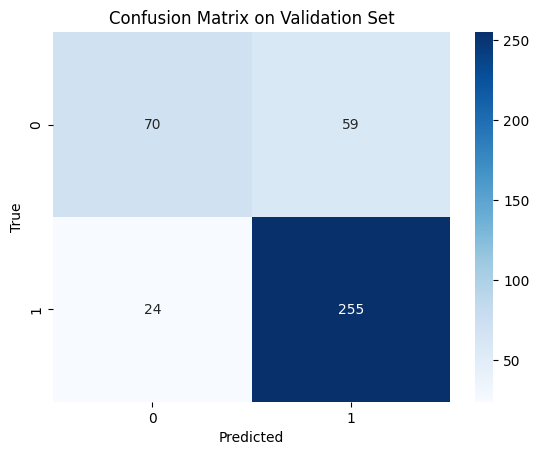

In [24]:
# 11. Visualize Confusion Matrix
# Get predictions
predictions = trainer.predict(encoded_dataset['validation'])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [25]:
# 12. Save Fine-tuned Model
trainer.save_model('./outputs/fine_tuned_bert_mrpc')
tokenizer.save_pretrained('./outputs/fine_tuned_bert_mrpc')


('./outputs/fine_tuned_bert_mrpc/tokenizer_config.json',
 './outputs/fine_tuned_bert_mrpc/special_tokens_map.json',
 './outputs/fine_tuned_bert_mrpc/vocab.txt',
 './outputs/fine_tuned_bert_mrpc/added_tokens.json',
 './outputs/fine_tuned_bert_mrpc/tokenizer.json')

In [26]:
# Step 1: Zip the folder
!zip -r outputs.zip outputs/

# Step 2: Now manually download outputs.zip from the sidebar

  adding: outputs/ (stored 0%)
  adding: outputs/fine_tuned_bert_mrpc/ (stored 0%)
  adding: outputs/fine_tuned_bert_mrpc/config.json (deflated 49%)
  adding: outputs/fine_tuned_bert_mrpc/special_tokens_map.json (deflated 42%)
  adding: outputs/fine_tuned_bert_mrpc/tokenizer.json (deflated 71%)
  adding: outputs/fine_tuned_bert_mrpc/training_args.bin (deflated 52%)
  adding: outputs/fine_tuned_bert_mrpc/model.safetensors (deflated 7%)
  adding: outputs/fine_tuned_bert_mrpc/tokenizer_config.json (deflated 75%)
  adding: outputs/fine_tuned_bert_mrpc/vocab.txt (deflated 53%)
  adding: outputs/logs/ (stored 0%)
  adding: outputs/logs/events.out.tfevents.1745681429.a0b728fb98f3.179.0 (deflated 62%)
  adding: outputs/checkpoints/ (stored 0%)
  adding: outputs/checkpoints/checkpoint-230/ (stored 0%)
  adding: outputs/checkpoints/checkpoint-230/optimizer.pt (deflated 21%)
  adding: outputs/checkpoints/checkpoint-230/config.json (deflated 49%)
  adding: outputs/checkpoints/checkpoint-230/schedu

In [30]:
from google.colab import files
files.download('outputs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>